# Import all packages/library.

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data Preparation

## Read Data File

In [2]:
# From the previous process, 
# we know that the raw data is already cleaned and ready-to-use.
raw_df = pd.read_csv('./data/retail_sales_synthetic.csv')
df = raw_df.copy()  # Copy to ensure every change made in this code doesn't affect the raw data.
# print(df.head())

Take meaningful columns only.

In [3]:
# From the previous process, 
# we know that there are several variables that has significant impact to sales and revenue.
df = df[[
    # Get the main necessary variables.
    'date', 'store_id', 'product_id',
    # Get the significantly impacted variables to be predicted.
    'net_units', 'net_revenue', 
    # Get the positively impactful variables.
    'store_type', 'promotion', 'is_holiday', 'weekend', 
    # Get the negatively impactful variables.
    'discount_pct'
    ]]

Convert `date` DataType to datetime.

In [4]:
df['date'] = pd.to_datetime(df['date'])

## Aggregate Data

We aim to build a monthly-based predictive model. Therefore, we aggregate the data on a monthly basis.

**Endogenous or Target Variables:**  
- Variables: Sales (`net_units`) and revenue (`net_revenue`).
- We sum these variables to obtain the total monthly sales and revenue, which lets us observe their changes in response to the exogenous factors.

**Exogenous or Regression Variables:**  
- Variables: Product's promotion flag (`promotion`), holiday flag (`is_holiday`), weekend flag (`weekend`), and product's discount percentage (`discount_pct`).
- For `promotion`, we need to calculate the proportion of transactions with promotion in a month.
- For `is_holiday`, we determine a monthly holiday flag since holiday effects typically span over a longer period rather than a single day.
- For `weekend`, we need to calculate the proportion of transactions during weekend in a month.
- For `discount_pct`, we need to calculate the average discount percentages given in a month (0-30%) as it is given per product.

In [5]:
df_monthly = (
    df.groupby(pd.Grouper(key='date', freq='ME'))   # Aggregate data by date in monthly frequency.
      .agg({
          'net_units': 'sum',
          'net_revenue': 'sum',
          'promotion': 'mean',      # Calculate promotion proportion in a month.
          'is_holiday': 'max',      # Label for holiday/non-holiday month.
          'weekend': 'mean',        # Calculate weekend proportion in a month.
          'discount_pct': 'mean'    # Calculate average discount given in a month.
          # To do overall performance analysis, store type is excluded to avoid bias.
      })
      .reset_index()
)

print(df_monthly.head())

        date  net_units  net_revenue  promotion  is_holiday   weekend  \
0 2022-01-31      18498    860972.53   0.084301           1  0.322581   
1 2022-02-28      16240    743945.03   0.078810           0  0.285714   
2 2022-03-31      18163    833257.90   0.075269           1  0.258065   
3 2022-04-30      17575    830541.04   0.085556           0  0.300000   
4 2022-05-31      18032    811823.17   0.080860           0  0.290323   

   discount_pct  
0      3.631183  
1      3.691667  
2      3.834409  
3      3.871111  
4      3.898925  


Visualize time series to show general patterns.

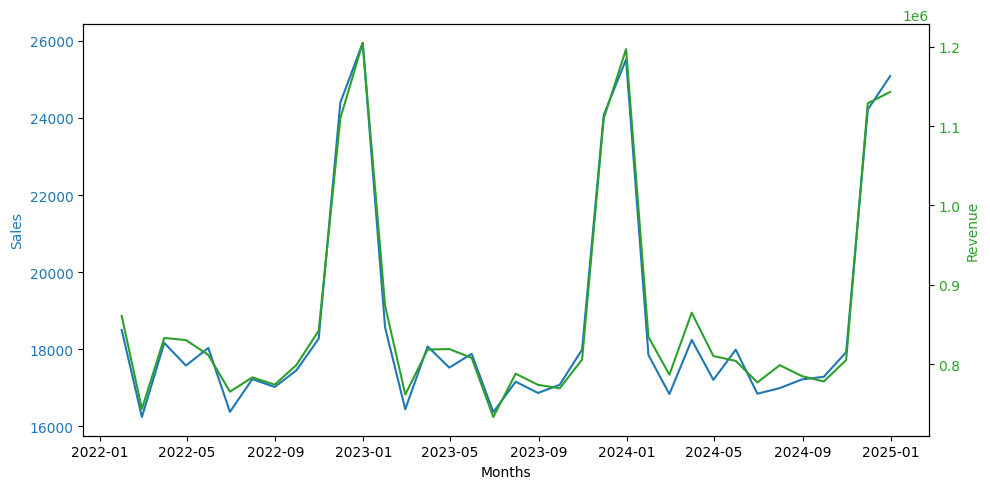

In [6]:
fig, ax1 = plt.subplots(figsize=(10,5))
color = 'tab:blue'
ax1.plot(df_monthly.set_index('date')['net_units'], color=color)
ax1.set_xlabel('Months')
ax1.set_ylabel('Sales', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.plot(df_monthly.set_index('date')['net_revenue'], color=color)
ax2.set_ylabel('Revenue', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()
plt.show()

## Split Dataset to Train and Test

As we know from the initial to EDA process, we have data of 36 months. In general, we split data in proportion of train:set by 80:20 ~ 70:30. In that case, we will have 30 months as the train data and 6 months as the test data.

In [7]:
h = 6 # Horizon (~20-30% of the total months)
train = df_monthly.iloc[:-h].copy()
test  = df_monthly.iloc[-h:].copy()

print(train.shape, test.shape)

(30, 7) (6, 7)


# Model Development

## Prepare Variables

In [8]:
y_cols = ['net_units', 'net_revenue']                           # Endogenous variables.
p_cols = ['promotion', 'is_holiday', 'weekend', 'discount_pct'] # Exogenous variables.

## Model Building

Based on the information we have (EDA and data time series visualization), we need an algorithm that can handle multiple exogenous variables and analyze seasonal peaks. A suitable algorithm for this case is SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variables).

### Scale Exogenous Variables
This step is necessary because the exogenous variables vary in scale.

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train[p_cols])
X_test  = scaler.transform(test[p_cols])

# Convert to DataFrames
X_train = pd.DataFrame(X_train, index=train.index, columns=p_cols)
X_test  = pd.DataFrame(X_test,  index=test.index,  columns=p_cols)

### Build Model Based on Decided Algorithm

In [10]:
models = {}                         # Models holder.

# Build model.
model_units = SARIMAX(
    endog=np.log1p(train['net_units']),       # Endogenous variable values.
    exog=X_train,                   # Exogenous variables values.
    order=(1,1,0),                  # p, d, q values in non-seasonal prediction.
    seasonal_order=(0,1,1,12),      # p, d, q, m values in seasonal prediction.
    enforce_stationarity=False, 
    enforce_invertibility=False
).fit(disp=False)

model_rev = SARIMAX(
    endog=np.log1p(train['net_revenue']),     # Endogenous variable values.
    exog=X_train,                   # Exogenous variables values.
    order=(1,0,1),                  # p, d, q values in non-seasonal prediction.
    seasonal_order=(0,1,1,12),      # p, d, q, m values in seasonal prediction.
    enforce_stationarity=False, 
    enforce_invertibility=False
).fit(disp=False)

# Save models to holder.
models['net_units'] = {'model': model_units}
models['net_revenue'] = {'model': model_rev}

C:\Users\Grace\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Grace\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Grace\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [11]:
# Predict yf based on Xf.
results = {}    # Prediction results holder.

for y_col in y_cols: 
    pred_log = models[y_col]['model'].get_forecast(steps=h, exog=X_test).predicted_mean
    pred = np.expm1(pred_log)
    results[y_col] = {'pred': pred}

**Tuning Process:**
- Autoregression (`p` or `P`)  
This variable is needed to capture the dependencies between past and present observations. However, too many autoregressive terms may lead to overfitting, capturing noise as if it were a real pattern. After the tuning process, I found that, in the non-seasonal part, `p=1` was sufficient to achieve the best results. On the other hand, in the seasonal part, excluding this variable yielded better performance.
- Differencing (`d` or `D`)  
The original time series already exhibits a stable trend, so applying too much differencing may remove the trend and make the data less interpretable. After the tuning process, I found that, in the non-seasonal part, `d=1` in sales model and `d=0` in revenue model was sufficient to achieve the best results. On the other hand, in the seasonal part, `d=1` in both was sufficient enough.
- Moving Average (`q` or `Q`)  
This variable is needed to capture short-term fluctuations, especially in the presence of noise. However, similar to autoregression, too many moving average terms can result in a model that is too responsive to short-term fluctuations, leading to overfitting. After the tuning process, I found that, in the non-seasonal part, `q=0` in sales model and `q=1` in revenue model was sufficient to achieve the best results. On the other hand, in the seasonal part, `q=1` in both was sufficient enough.
- Seasonal Period (`m`)
An incorrect seasonal period may cause the model to capture non-existent seasonal patterns. The data time series visualization shows a clear seasonality (12 months period), making this parameter the most appropriate choice.

### Evaluate The Model Performance

Two common metrics are used to evaluate the forecasting performance.
- **Mean Absolute Error (MAE):**  
Measures the average magnitude of errors in the same scale as the data. Lower MAE indicates better model accuracy. 
- **Mean Absolute Percentage Error (MAPE):**  
Represents the average error as a percentage of the actual values. A smaller MAPE indicates higher accuracy. Generally, MAPE <10% is often considered excellent, 10–20% good, 20–50% reasonable, and >50% poor. Note that these thresholds are context-dependent, but they are fairly reasonable for this dataset.

In this project, MAPE is more intuitive to interpret since it shows how far the predictions deviate from actual sales and revenue in percentage terms.


In [12]:
eval = {}               # Evaluation results holder.

for i, y_col in enumerate(y_cols):
    # Evaluate model.
    mae = mean_absolute_error(test[y_col], results[y_col]['pred'])
    mape = mean_absolute_percentage_error(test[y_col], results[y_col]['pred'])*100
    eval[y_col] = {'MAE': mae, 'MAPE': mape}

In [13]:
# Print evaluation results.
for y_col in y_cols:
    if y_col == 'net_units':
        print('Sales Model → ', end='')
    elif y_col == 'net_revenue':
        print(f'Revenue Model → ', end='')
    print(f"MAE: {eval[y_col]['MAE']:,.0f} | MAPE: {eval[y_col]['MAPE']:.2f}%")

Sales Model → MAE: 100 | MAPE: 0.50%
Revenue Model → MAE: 12,912 | MAPE: 1.44%


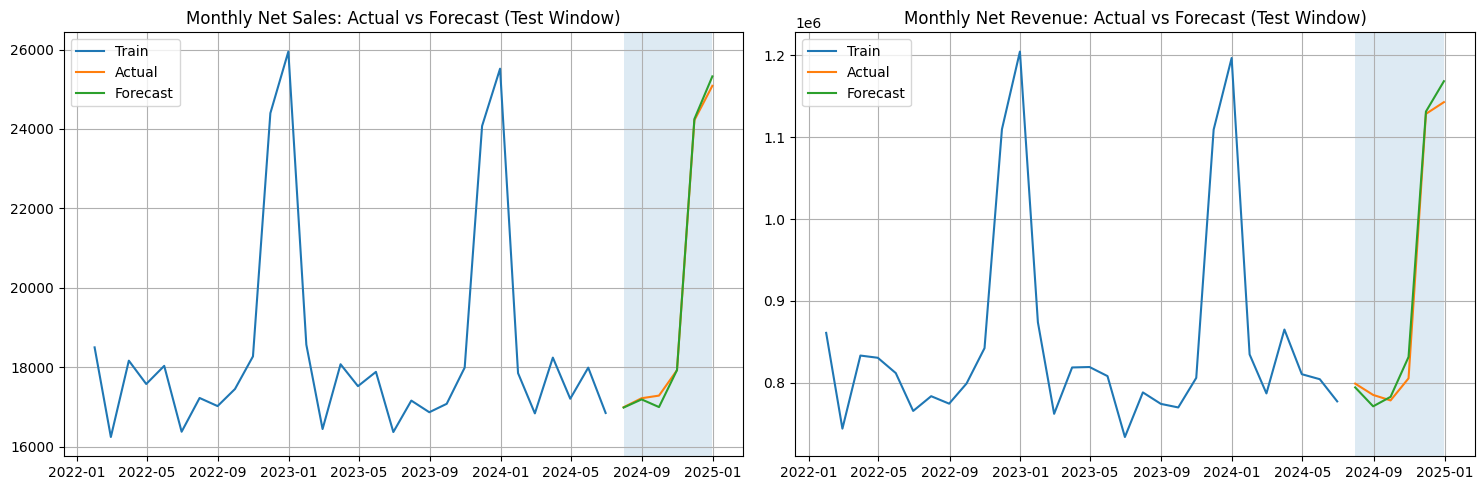

In [14]:
# Visualize model.
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i, y_col in enumerate(y_cols):
    ax[i].plot(train['date'], train[y_col], label='Train')
    ax[i].plot(test['date'],  test[y_col],  label='Actual')
    ax[i].plot(test['date'],  results[y_col]['pred'], label='Forecast')
    ax[i].axvspan(test['date'].min(), test['date'].max(), alpha=0.15)
    if y_col == 'net_units':
        ax[i].set_title('Monthly Net Sales: Actual vs Forecast (Test Window)')
    elif y_col == 'net_revenue':
        ax[i].set_title('Monthly Net Revenue: Actual vs Forecast (Test Window)')
    ax[i].grid(visible=True)
    ax[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

The sales model tracks the late-2024 surge closely with only minor deviations in the test window. For the revenue model, small errors remain at the peak months, which is a reasonable outcome given the higher volatility of revenue data.

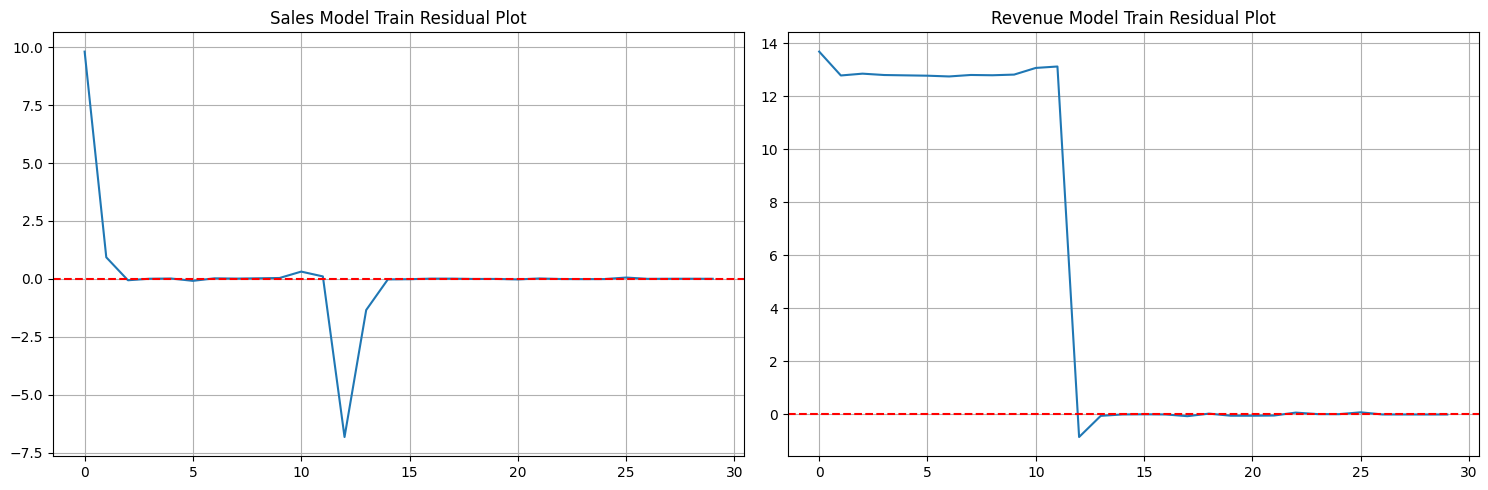

In [15]:
# Visualize train residual plot.
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i, y_col in enumerate(y_cols):
    resid = models[y_col]['model'].resid
    ax[i].plot(resid)
    if y_col == 'net_units':
        ax[i].set_title('Sales Model Train Residual Plot')
    elif y_col == 'net_revenue':
        ax[i].set_title('Revenue Model Train Residual Plot')
    ax[i].axhline(0, color='r', linestyle='--')
    ax[i].grid(visible=True)

plt.tight_layout()
plt.show()

The sales model exhibits a single sharp negative residual during the training period, indicating a temporary overprediction in one month.
On the other hand, the revenue model exhibits a prolonged positive bias at the beginning, indicating the need for additional seasonal flexibility.

Nevertheless, both models' residuals quickly return to near-zero levels, implying that the models adapt well and do not exhibit systematic bias. Such one-off residual spikes are common when a model first learns a seasonal pattern or when historical outliers occur in the data.

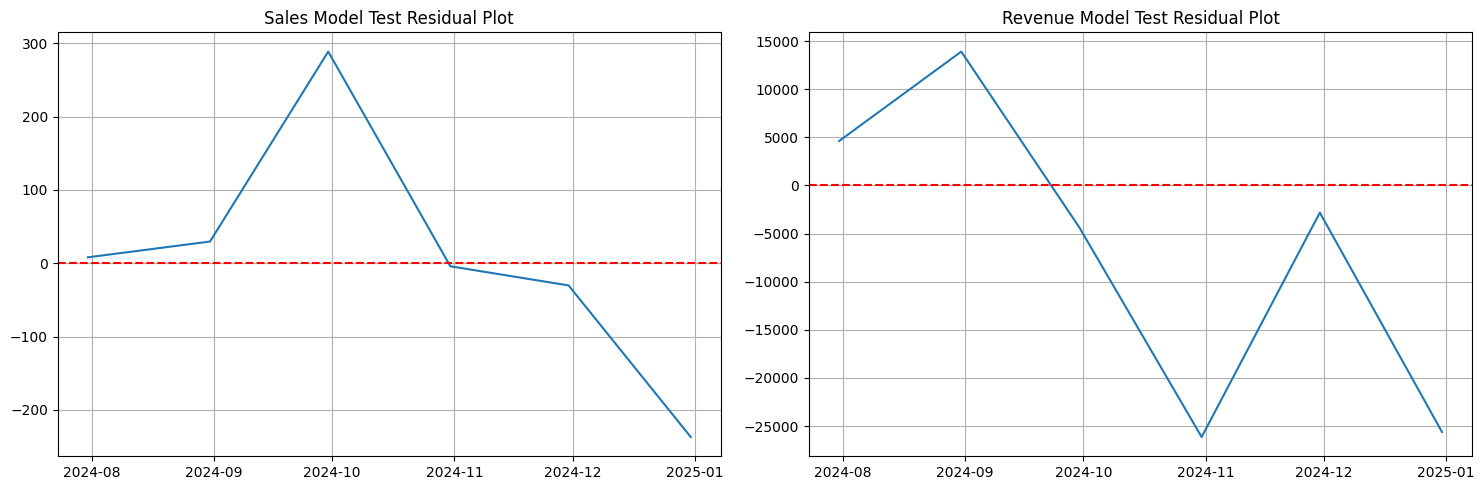

In [16]:
# Visualize test residual plot.
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i, y_col in enumerate(y_cols):
    resid = test[y_col] - results[y_col]['pred']
    ax[i].plot(test['date'], resid)
    if y_col == 'net_units':
        ax[i].set_title('Sales Model Test Residual Plot')
    elif y_col == 'net_revenue':
        ax[i].set_title('Revenue Model Test Residual Plot')
    ax[i].axhline(0, color='r', linestyle='--')
    ax[i].grid(visible=True)

plt.tight_layout()
plt.show()

The residual plots confirm the earlier findings: slight initial underfitting in the sales model and higher sensitivity which led to bias in the revenue model.

### Baseline Model
A baseline comparison (e.g., Seasonal Naïve) could be applied to benchmark SARIMAX performance. However, since SARIMAX already captures both trend and seasonality effectively, and the dataset is relatively short, this comparison is omitted to avoid redundancy.

## Save Model

Saving the trained models ensures reproducibility and allows future forecasting using new data without retraining from scratch.  

**Note:** To reuse the model effectively, the input features and seasonal pattern should remain consistent with the trained model. Otherwise, performance may degrade.

In [17]:
models['net_units']['model'].save('model_net_units.pkl')
models['net_revenue']['model'].save('model_net_revenue.pkl')
joblib.dump(scaler, 'models_exog_scaler.pkl')

['models_exog_scaler.pkl']